# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Грачев Денис Вадимович

**Дедлайн**: 09 октября 2020

In [1]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(
        path,
        '%s-labels-idx1-ubyte.gz'
        % kind
    )

    images_path = os.path.join(
        path,
        '%s-images-idx3-ubyte.gz'
        % kind
    )

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(
            lbpath.read(), 
            dtype=np.uint8,
            offset=8
        )

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(
            imgpath.read(), 
            dtype=np.uint8,
            offset=16
        ).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [5]:
import os

class FashionMnist(Dataset):
    def __init__(
            self, 
            path, 
            train=True, 
            image_transform=None,
            label_transform=None
        ):

        if train:
            images, labels = load_mnist(os.path.join(path, "raw"))
        else:
            images, labels = load_mnist(os.path.join(path, "raw"), kind="t10k")

        self.images = images.reshape(-1, 28, 28)
        self.labels = labels

        if image_transform is not None:
            self.images = image_transform(self.images)
        
        if label_transform is not None:
            self.labels = label_transform(self.labels)

    def __len__(self,):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [6]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

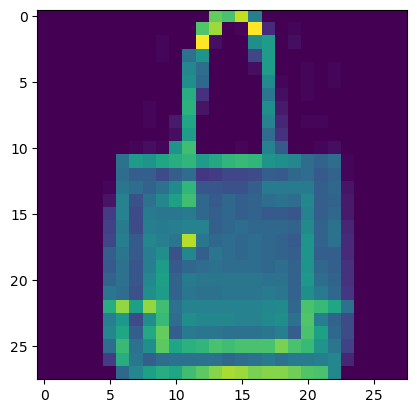

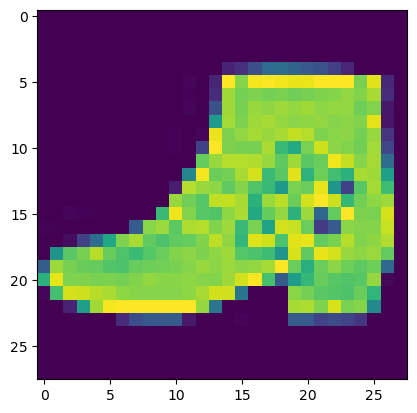

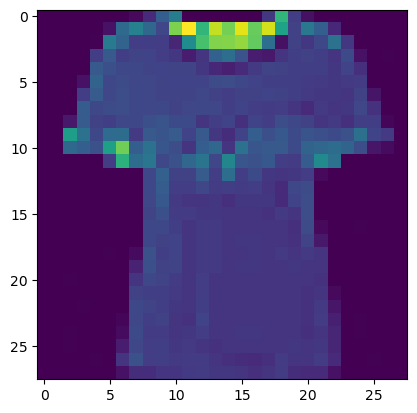

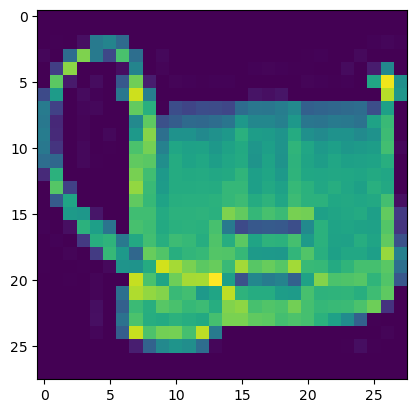

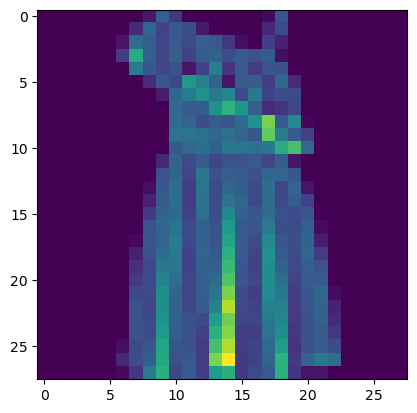

In [7]:
idxs = np.random.randint(0, len(train_dataset), size=5)
for idx in idxs:
    img, _ = train_dataset[idx]
    plt.imshow(img)
    plt.show()

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [8]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [9]:
transform = ToTensor()

test_dataset = FashionMnist(
    "data/FashionMNIST",
    train=False,
    image_transform=transform,
    label_transform=transform
)

train_dataset = FashionMnist(
    "data/FashionMNIST",
    image_transform=transform,
    label_transform=transform
)

/tmp/ipykernel_4491/2643605458.py:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(sample)


In [10]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или объединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [11]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [12]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [13]:
def collate(batch):

    x_shape = batch[0][0].shape
    y_shape = batch[0][1].shape

    imgs = torch.zeros(len(batch), *x_shape)
    labels = torch.zeros(len(batch), *y_shape)

    for i, (x, y) in enumerate(batch):
        imgs[i] = x
        labels[i] = y

    return imgs, labels.long()

Убедитесть, что все работает корректно.

In [14]:
test_dataloader = DataLoader(
    test_dataset, batch_size=15, num_workers=2,
    shuffle=True, collate_fn=collate
)

train_dataloader = DataLoader(
    train_dataset, batch_size=15, num_workers=2,
    shuffle=True, collate_fn=collate
)

batch = next(iter(test_dataloader))

In [15]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [16]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [17]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [18]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        val = torch.where(input > 0, input, 0)
        ctx.save_for_backward(val)

        return val

    @staticmethod
    def backward(ctx, grad_output):
        val, = ctx.saved_tensors
        grad = grad_output * torch.where(val > 0, 1, 0)
        
        return grad

In [19]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLUFunction.apply

    def forward(self, input):
        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [20]:
relu = ReLUFunction.apply
x = torch.rand((3, 2), requires_grad=True).double()
assert gradcheck(relu, x)

In [21]:
torch_relu = torch.nn.functional.relu
our_relu = ReLUFunction.apply

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [22]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        output = inp @ weight.T + bias

        ctx.save_for_backward(inp, weight)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        inp, weight = ctx.saved_tensors
        
        grad_input = grad_output @ weight

        # ( ✜︵✜ )
        grad_weight = inp.view(inp.shape[0], 1, inp.shape[1]) * grad_output.view(*grad_output.shape, 1)
        grad_bias = grad_output 

        return grad_input, grad_weight, grad_bias

In [50]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        # initialize weights with small random numbers from normal distribution
        
        self.linear = LinearFunction().apply
        self.weight = nn.Parameter(torch.zeros(output_units, input_units))
        self.bias = nn.Parameter(torch.zeros(output_units))
        
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, inp):
        return self.linear(inp, self.weight, self.bias)


In [51]:
model = nn.Sequential(
    Linear(1, 1)
)

# optimizer = Adam(model.parameters())
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=1e-2, 
    momentum=0
)

x = torch.tensor([[1.], [2.], [3.]])
y = torch.tensor([[1.], [3.], [5.]])

for i in range(1000):
    y_pred = model(x)
    loss = ((y - y_pred) ** 2).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(loss)

tensor(20.7030, grad_fn=<SumBackward0>)
tensor(0.0325, grad_fn=<SumBackward0>)
tensor(0.0076, grad_fn=<SumBackward0>)
tensor(0.0018, grad_fn=<SumBackward0>)
tensor(0.0004, grad_fn=<SumBackward0>)
tensor(9.9219e-05, grad_fn=<SumBackward0>)
tensor(2.3330e-05, grad_fn=<SumBackward0>)
tensor(5.4847e-06, grad_fn=<SumBackward0>)
tensor(1.2895e-06, grad_fn=<SumBackward0>)
tensor(3.0320e-07, grad_fn=<SumBackward0>)


Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [52]:
linear = LinearFunction().apply

weight = torch.rand((2, 3)).double()
bias = torch.rand((2, )).double()
x = torch.rand((10, 3), requires_grad=True).double()
assert gradcheck(linear, (x, weight, bias))

weight = torch.rand((2, 3), requires_grad=True).double()
bias = torch.rand((2,)).double()
x = torch.rand((10, 3)).double()
assert gradcheck(linear, (x, weight, bias))

weight = torch.rand((2, 3)).double()
bias = torch.rand((2,), requires_grad=True).double()
x = torch.rand((10, 3)).double()
assert gradcheck(linear, (x, weight, bias))

weight = torch.rand((2, 3), requires_grad=True).double()
bias = torch.rand((2,), requires_grad=True).double()
x = torch.rand((10, 3), requires_grad=True).double()
assert gradcheck(linear, (x, weight, bias))

Сравнение с `PyTorch`.

In [53]:
weight = torch.rand((2, 3), requires_grad=True)
bias = torch.rand((2,), requires_grad=True)
x = torch.rand((10, 3), requires_grad=True)

torch_linear = torch.nn.Linear(in_features=3, out_features=2)
our_linear = Linear(input_units=3, output_units=2)

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

torch_y = torch_linear(x)
our_y = our_linear(x)

assert torch.allclose(torch_y, our_y)

rand_mask = torch.rand(torch_y.shape)
(torch_y * rand_mask).sum().backward()
(our_y * rand_mask).sum().backward()

In [54]:
assert torch.allclose(our_linear.weight.grad, torch_linear.weight.grad)
assert torch.allclose(our_linear.bias.grad, torch_linear.bias.grad)

### 2.3 LogSoftmax (Log + Softmax)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Комментарий: разобраться `Log-Sum-Exp trick`

In [55]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):

        logval = inp - torch.logsumexp(inp, dim=1).view(-1, 1)
        ctx.save_for_backward(logval)

        return logval

    @staticmethod
    def backward(ctx, grad_output):

        logval, = ctx.saved_tensors
        val = torch.exp(logval)

        grad = torch.where(
            torch.abs(grad_output) > 0,
            1 - val,
            -val
        )

        my_max, _ = torch.max(grad_output, dim=1)
        my_min, _ = torch.min(grad_output, dim=1)

        grad_output = torch.where(
            my_max > -my_min,
            my_max,
            my_min
        )

        return grad * grad_output.view(-1, 1)


In [56]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.logsoftmax = LogSoftmaxFunction.apply

    def forward(self, input):
        return self.logsoftmax(input)

Проверка градиентов.

In [57]:
logsoftmax = LogSoftmaxFunction.apply
x = torch.randn((2, 3), requires_grad=True).double()
assert gradcheck(logsoftmax, x)

In [58]:
our_x = torch.arange(12, dtype=float).reshape(4, 3)
our_x = our_x.requires_grad_(True)
our_y = logsoftmax(our_x)
(our_y[0, 0] + our_y[1, 0] + our_y[2, 2] + our_y[3, 1]).sum().backward()

torch_x = torch.arange(12, dtype=float).reshape(4, 3)
torch_x = torch_x.requires_grad_(True)
torch_y = nn.LogSoftmax(dim=1)(torch_x)
(torch_y[0, 0] + torch_y[1, 0] + torch_y[2, 2] + torch_y[3, 1]).sum().backward()

In [59]:
assert torch.allclose(our_x.grad, torch_x.grad)

### 2.4 Dropout
Реализуйте слой Dropout.

In [60]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):
        
        probs = torch.ones_like(inp) * (1 - p)
        mask = torch.bernoulli(probs)
        ctx.save_for_backward(mask)

        return inp * mask / (1 - p)

    @staticmethod
    def backward(ctx, grad_output):
        
        mask, = ctx.saved_tensors
        return grad_output * mask, None

In [61]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.dropout = DropoutFunction().apply
        self.p = torch.tensor(p)

    def forward(self, input):
        if self.training:
            return self.dropout(input, self.p)
        else:
            return input

### 2.5 CrossEntropy

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь кроссэнтропию. Реализуйте функцию потерь. В разделе 2.3 приведены полезные формулы.

In [62]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):

        val = -activations[:, target].diag()
        ctx.save_for_backward(target, activations)

        return val

    @staticmethod
    def backward(ctx, grad_output):
        target, activations = ctx.saved_tensors

        size = activations.shape[0] * activations.shape[1]
        ids = torch.arange(size).reshape(activations.shape) % activations.shape[1]
        ids = ids.to(target.device)
        mask = torch.eq(ids, target.view(-1, 1))
        grad = torch.where(
            mask,
            1,
            0.
        )

        return -grad * grad_output.view(-1, 1), torch.zeros_like(target)

        
class CrossEntropy(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.cross_entropy = CrossEntropyFunction.apply

    def forward(self, activations, target):
        return self.cross_entropy(activations, target)

Проверка градиентов.

In [63]:
activations = torch.maximum(
    torch.normal(mean=torch.ones(2, 5)),
    torch.zeros(2, 5) + 0.1
).clone().detach().requires_grad_(True).double()

target = torch.tensor([2, 0])

In [64]:
cross_entropy = CrossEntropyFunction.apply

activations = torch.maximum(
    torch.normal(mean=torch.ones(2, 5)),
    torch.zeros(2, 5) + 0.1
).clone().detach().requires_grad_(True).double()

target = torch.tensor([2, 0])

assert gradcheck(cross_entropy, (activations, target))


## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

Без копирования начальных весов у меня не обучается

In [84]:
def my_linear_from_torch(torch_linear):
    out_features = torch_linear.weight.shape[0]
    in_features = torch_linear.weight.shape[1]


    my_linear = Linear(in_features, out_features)
    my_linear.weight.data = torch_linear.weight.detach()
    my_linear.bias.data = torch_linear.bias.detach()

    return my_linear

In [86]:
class Network(nn.Module):
    def __init__(
            self, 
            input_size=28*28, hidden_layers_size=32, num_layers=5,
            num_classes=10
        ):

        super().__init__()

        layers = [
            nn.Flatten(),
            my_linear_from_torch(nn.Linear(input_size, hidden_layers_size * 3)),
            ReLU(),
            Dropout(0.05),
            my_linear_from_torch(nn.Linear(hidden_layers_size * 3, hidden_layers_size * 5)),
            ReLU(),
            Dropout(0.05),
            my_linear_from_torch(nn.Linear(hidden_layers_size * 5, hidden_layers_size * 3)),
            ReLU(),
            Dropout(0.05),
            my_linear_from_torch(nn.Linear(hidden_layers_size * 3, hidden_layers_size)),
            ReLU(),
            Dropout(0.05),
            my_linear_from_torch(nn.Linear(hidden_layers_size, num_classes)),
            ReLU(),
            LogSoftmax(),
        ]

        self.conveyor = nn.Sequential(*layers)

    def forward(self, inp):
        return self.conveyor(inp)

    def predict(self, inp):
        return torch.argmax(self.forward(inp), dim=1)


Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать.

In [87]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [88]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
    return torch.mean((model_labels == labels).float())

In [89]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels).sum()
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step()

            one_batch_loss = float(criterion(model_labels, batch_labels).sum())
            one_batch_acc = accuracy(model_prediction, batch_labels)

            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1
    return (total_loss / total_n, total_acc / total_n)

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [90]:
model = Network()
optimizer = Adam(model.parameters())
criterion = CrossEntropy()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 12.956832684099675, accuracy 0.6946094632148743
Current learning rate: 0.001
Epoch - 1 : loss 7.791673415660858, accuracy 0.8202338218688965
Current learning rate: 0.001
Epoch - 2 : loss 7.329565375208855, accuracy 0.830884575843811
Current learning rate: 0.001
Epoch - 3 : loss 6.940566541671753, accuracy 0.8404515385627747
Current learning rate: 0.001
Epoch - 4 : loss 6.834249845921994, accuracy 0.8408344984054565
Current learning rate: 0.001
Epoch - 5 : loss 6.570844908118248, accuracy 0.8479849696159363
Current learning rate: 0.001
Epoch - 6 : loss 6.470608317613602, accuracy 0.8504514694213867
Current learning rate: 0.001
Epoch - 7 : loss 6.446125644207001, accuracy 0.8495015501976013
Current learning rate: 0.001
Epoch - 8 : loss 6.22940181234479, accuracy 0.8557342290878296
Current learning rate: 0.001
Epoch - 9 : loss 6.214803452551365, accuracy 0.8558012843132019
Current learning rate: 0.001


Я заметил что результаты не очень консистенты от запуска к запуску  
и бывает сильно меняются если переинциализировать веса и запустить обучение

Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [ ]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.